### This example demonstrates the XCSF supervised learning mechanisms to perform classification
Classifiers are composed of neural network conditions and predictions. A softmax layer is used as prediction output and labels are one-hot encoded. Similar to regression, a single dummy action is performed such that [A] = [M].

In [1]:
from __future__ import annotations

import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm import tqdm

import xcsf

RANDOM_STATE: int = 10
np.random.seed(RANDOM_STATE)

### Load training and test data
Loads USPS data from: https://www.openml.org/d/41082 

"Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990)."

In [2]:
# 256 features, 10 classes, 9298 instances
data = fetch_openml(data_id=41082, parser="auto")
INPUT_HEIGHT: int = 16
INPUT_WIDTH: int = 16
INPUT_CHANNELS: int = 1

# numpy
X = np.asarray(data.data, dtype=np.float64)
y = np.asarray(data.target, dtype=np.int16)

# scale features [0,1]
feature_scaler = MinMaxScaler()
X = feature_scaler.fit_transform(X)

# USPS labels start at 1
y = np.subtract(y, 1)

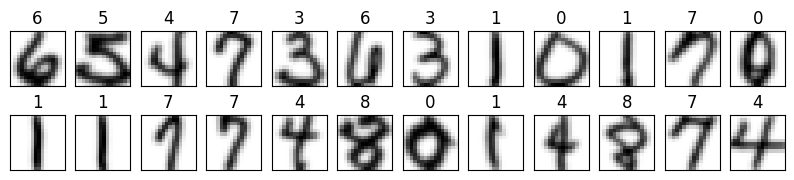

In [3]:
plt.figure(figsize=(10, 2))
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(X[i].reshape(INPUT_WIDTH, INPUT_HEIGHT), cmap="gray_r")
    plt.title(f"{y[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
# one hot encode labels
onehot_encoder = OneHotEncoder(sparse_output=False, categories="auto")
y = onehot_encoder.fit_transform(y.reshape(-1, 1))

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE
)

# 10% of training for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_STATE
)

# get number of input and output variables
X_DIM: int = np.shape(X_train)[1]
Y_DIM: int = np.shape(y_train)[1]

print(f"X_train shape = {np.shape(X_train)}")
print(f"y_train shape = {np.shape(y_train)}")
print(f"X_val shape = {np.shape(X_val)}")
print(f"y_val shape = {np.shape(y_val)}")
print(f"X_test shape = {np.shape(X_test)}")
print(f"y_test shape = {np.shape(y_test)}")

X_train shape = (7531, 256)
y_train shape = (7531, 10)
X_val shape = (837, 256)
y_val shape = (837, 10)
X_test shape = (930, 256)
y_test shape = (930, 10)


### Initialise XCSF

In [5]:
ACTIVATION: str = "selu"
SGD_WEIGHTS: bool = True
EVOLVE_WEIGHTS: bool = True
EVOLVE_CONNECT: bool = True
EVOLVE_ETA: bool = True
EVOLVE_NEURONS: bool = True
ETA: float = 0.01
ETA_MIN: float = 0.00001
MOMENTUM: float = 0.9
DECAY: float = 0
N_INIT: int = 16
N_MAX: int = 100
MAX_GROW: int = 1

LAYER_CONV: dict = {
    "type": "convolutional",
    "activation": ACTIVATION,
    "sgd_weights": SGD_WEIGHTS,
    "evolve_weights": EVOLVE_WEIGHTS,
    "evolve_connect": EVOLVE_CONNECT,
    "evolve_eta": EVOLVE_ETA,
    "evolve_neurons": EVOLVE_NEURONS,
    "max_neuron_grow": MAX_GROW,
    "eta": ETA,
    "eta_min": ETA_MIN,
    "momentum": MOMENTUM,
    "decay": DECAY,
    "n_init": N_INIT,
    "n_max": N_MAX,
    "stride": 1,
    "size": 3,
    "pad": 1,
    "height": INPUT_HEIGHT,
    "width": INPUT_WIDTH,
    "channels": INPUT_CHANNELS,
}

LAYER_MAXPOOL: dict = {
    "type": "maxpool",
    "stride": 2,
    "size": 2,
    "pad": 0,
    "height": INPUT_HEIGHT,
    "width": INPUT_WIDTH,
    "channels": INPUT_CHANNELS,
}

LAYER_CONNECTED: dict = {
    "type": "connected",
    "activation": ACTIVATION,
    "sgd_weights": SGD_WEIGHTS,
    "evolve_weights": EVOLVE_WEIGHTS,
    "evolve_connect": EVOLVE_CONNECT,
    "evolve_eta": EVOLVE_ETA,
    "evolve_neurons": EVOLVE_NEURONS,
    "max_neuron_grow": MAX_GROW,
    "eta": ETA,
    "eta_min": ETA_MIN,
    "momentum": MOMENTUM,
    "decay": DECAY,
    "n_init": N_INIT,
    "n_max": N_MAX,
}

MAX_TRIALS: int = 200000
E0: float = 0.01  # target error

xcs = xcsf.XCS(
    x_dim=X_DIM,
    y_dim=Y_DIM,
    n_actions=1,
    omp_num_threads=12,
    random_state=RANDOM_STATE,
    pop_size=100,
    max_trials=MAX_TRIALS,
    perf_trials=1000,
    loss_func="onehot",  # one-hot encoding classification error
    e0=E0,
    alpha=1,
    beta=0.05,
    delta=0.1,
    theta_del=100,
    nu=5,
    ea={
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": False,
        "pred_reset": False,
    },
    action={
        "type": "integer",
    },
    condition={
        "type": "neural",
        "args": {
            "layer_0": {  # hidden layer
                "type": "connected",
                "activation": ACTIVATION,
                "evolve_weights": EVOLVE_WEIGHTS,
                "evolve_connect": EVOLVE_CONNECT,
                "evolve_neurons": EVOLVE_NEURONS,
                "n_init": 1,
                "n_max": N_MAX,
                "max_neuron_grow": MAX_GROW,
            },
            "layer_1": {  # output layer
                "type": "connected",
                "activation": "linear",
                "evolve_weights": EVOLVE_WEIGHTS,
                "evolve_connect": EVOLVE_CONNECT,
                "n_init": 1,
            },
        },
    },
    prediction={
        "type": "neural",
        "args": {
            "layer_0": LAYER_CONV,
            "layer_1": LAYER_MAXPOOL,
            "layer_2": LAYER_CONV,
            "layer_3": LAYER_MAXPOOL,
            "layer_4": LAYER_CONNECTED,
            "layer_out1": {  # output layer - softmax composed of two layers
                "type": "connected",
                "activation": "linear",
                "sgd_weights": SGD_WEIGHTS,
                "evolve_weights": EVOLVE_WEIGHTS,
                "evolve_connect": EVOLVE_CONNECT,
                "evolve_eta": EVOLVE_ETA,
                "eta": ETA,
                "eta_min": ETA_MIN,
                "momentum": MOMENTUM,
                "decay": DECAY,
                "n_init": Y_DIM,
            },
            "layer_out2": {  # output layer - softmax composed of two layers
                "type": "softmax",
                "scale": 1,
            },
        },
    },
)

print(json.dumps(xcs.internal_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 256,
    "y_dim": 10,
    "n_actions": 1,
    "omp_num_threads": 12,
    "random_state": 10,
    "population_file": "",
    "pop_init": true,
    "max_trials": 200000,
    "perf_trials": 1000,
    "pop_size": 100,
    "loss_func": "onehot",
    "set_subsumption": false,
    "theta_sub": 100,
    "e0": 0.01,
    "alpha": 1,
    "nu": 5,
    "beta": 0.05,
    "delta": 0.1,
    "theta_del": 100,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": false,
        "pred_reset": false
    },
    "condition": {
        "type": "neural",
        "args": {
            "layer_0": {
                "type": "connected",
                "activation": "selu",
                "n_inputs": 256,
             

### Fit XCSF

In [6]:
# use optional callback
callback = xcsf.EarlyStoppingCallback(
    # note: PERF_TRIALS is considered an "epoch" for callbacks
    monitor="val",  # which metric to monitor: {"train", "val"}
    patience=20000,  # trials with no improvement after which training will be stopped
    restore_best=True,  # whether to make checkpoints and restore best population
    min_delta=0,  # minimum change to qualify as an improvement
    start_from=0,  # trials to wait before starting to monitor improvement
    verbose=True,  # whether to display when checkpoints are made
)

xcs.fit(
    X_train, y_train, validation_data=(X_val, y_val), callbacks=[callback], verbose=True
)

00:00:01.712 trials=0 train=0.23200 val=0.15532 pset=100.0 mset=19.4 mfrac=0.99
checkpoint: 0.15532 error at 0 trials
00:00:03.295 trials=1000 train=0.11000 val=0.11231 pset=100.0 mset=36.5 mfrac=1.00
checkpoint: 0.11231 error at 1000 trials
00:00:04.710 trials=2000 train=0.06400 val=0.09080 pset=100.0 mset=46.3 mfrac=0.29
checkpoint: 0.09080 error at 2000 trials
00:00:07.743 trials=3000 train=0.05600 val=0.09677 pset=100.0 mset=52.9 mfrac=1.00
00:00:09.506 trials=4000 train=0.07000 val=0.06810 pset=100.0 mset=55.6 mfrac=1.00
checkpoint: 0.06810 error at 4000 trials
00:00:09.900 trials=5000 train=0.03300 val=0.07646 pset=100.0 mset=61.2 mfrac=0.71
00:00:12.377 trials=6000 train=0.03600 val=0.06691 pset=100.0 mset=79.1 mfrac=1.00
checkpoint: 0.06691 error at 6000 trials
00:00:15.114 trials=7000 train=0.04900 val=0.06571 pset=100.0 mset=90.1 mfrac=0.88
checkpoint: 0.06571 error at 7000 trials
00:00:15.275 trials=8000 train=0.03000 val=0.05257 pset=100.0 mset=89.1 mfrac=1.00
checkpoint: 0

### Plot XCSF learning performance

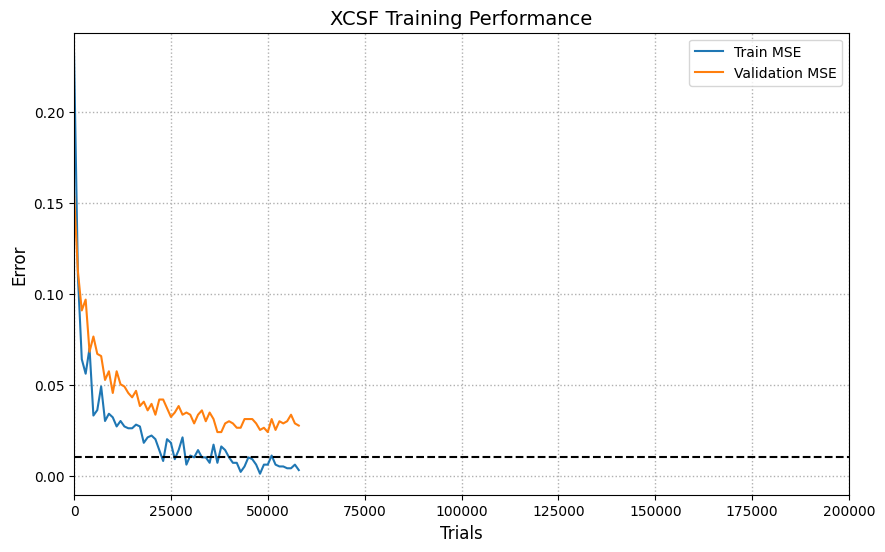

In [7]:
metrics: dict = xcs.get_metrics()
plt.figure(figsize=(10, 6))
plt.plot(metrics["trials"], metrics["train"], label="Train Error")
plt.plot(metrics["trials"], metrics["val"], label="Validation Error")
plt.grid(linestyle="dotted", linewidth=1)
plt.axhline(y=E0, xmin=0, xmax=1, linestyle="dashed", color="k")
plt.title("XCSF Training Performance", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xlim([0, MAX_TRIALS])
plt.legend()
plt.show()

### Final XCSF test score

In [9]:
pred = xcs.predict(X_test)  # soft max predictions
pred = np.argmax(pred, axis=1)  # select most likely class
pred = onehot_encoder.transform(pred.reshape(-1, 1))
inv_y_test = onehot_encoder.inverse_transform(y_test)
inv_pred = onehot_encoder.inverse_transform(pred)
print(classification_report(inv_y_test, inv_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9941    0.9941    0.9941       169
           1     0.9913    0.9913    0.9913       115
           2     0.9789    0.9789    0.9789        95
           3     0.9851    0.9167    0.9496        72
           4     0.9655    1.0000    0.9825        84
           5     0.9500    0.9620    0.9560        79
           6     0.9740    0.9868    0.9804        76
           7     0.9659    0.9551    0.9605        89
           8     0.9851    0.9851    0.9851        67
           9     0.9647    0.9762    0.9704        84

    accuracy                         0.9774       930
   macro avg     0.9755    0.9746    0.9749       930
weighted avg     0.9775    0.9774    0.9773       930



### Confusion Matrix

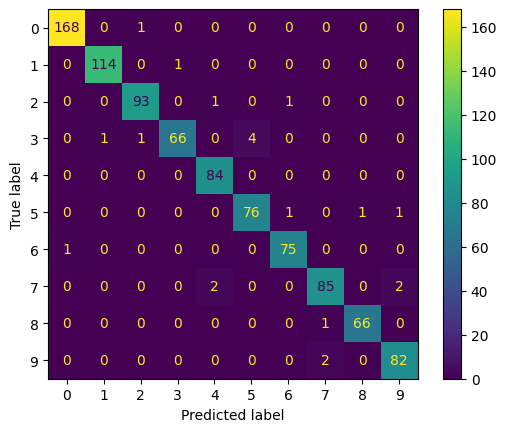

In [10]:
cm = confusion_matrix(inv_y_test, inv_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()